# PETH Tutorial

## Overview: The Power of `peth`

The `peth` function is a **unified, high-level interface** for computing peri-event time histograms (PETHs) across all major nelpy data types. Instead of writing separate analysis code for different neural signal types, `peth` handles the complexity seamlessly:

**What makes `peth` powerful:**
- **Universal input handling**: Works with spike trains, events, continuous signals (LFP, position, accelerometer), and more
- **Batch processing**: Automatically aligns and aggregates multiple signals/cells without manual iteration loops
- **Data type flexibility**: Accepts nelpy objects (SpikeTrainArray, EventArray, AnalogSignalArray, PositionArray), binned data (BinnedSpikeTrainArray, BinnedEventArray), and numpy arrays
- **Consistent output**: Always returns a DataFrame with intuitive time and signal dimensions for straightforward visualization and analysis
- **Zero boilerplate**: Focus on your neuroscience question, not data structure conversions

This tutorial demonstrates the versatility of `peth` using real neural data from a single recording session, showing how the same function elegantly handles spike rasters, continuous signals, and complex multi-region analyses.

## Import Required Libraries

This tutorial shows how to compute peri-event time histograms (PETHs) for multiple data types using `peth` and how to visualize the results with a real session.

In [1]:
import matplotlib.pyplot as plt
import nelpy as nel
import numpy as np
import seaborn as sns

import neuro_py as npy
from neuro_py.io import loading
from neuro_py.process.peri_event import peth

## Load Sample Neural Data

We load real data from a single session: **HMC1** on **day 8**. This session contains:
- **Spike trains** from CA1 and PFC pyramidal cells (well-characterized, prevalent populations)
- **Event timestamps** for ripples (sharp-wave ripples) and delta waves (slow oscillations during sleep)
- **Continuous signals** (LFP) recorded simultaneously from multiple brain regions

By loading from a single basepath, we ensure temporal alignment across all data types (spikes start at t=0, events logged with absolute timestamps, LFP sampled continuously).

Session basepath: `S:\data\HMC\HMC1\day8`

In [2]:
# Set session path
basepath = r"S:\data\HMC\HMC1\day8"

# Define LFP channels of interest:
#  - ripple_channel (261): CA1 pyramidal layer (ripple-rich)
#  - sharp_wave_channel (282): CA1 region (source of sharp waves)
#  - delta_channel (53): PFC region with delta oscillations during NREM
ripple_channel = 261
sharp_wave_channel = 282
delta_channel = 53

# Load spike trains with metadata
# Filter: only include cells recorded from CA1 and PFC with putative type 'Pyr' (pyramidal)
st, cell_metrics = npy.io.load_spikes(
    basepath, brainRegion="CA1|PFC", putativeCellType="Pyr"
)

# Create binary masks for brain region separation
ca1_idx = cell_metrics.brainRegion.str.contains("CA1").values
pfc_idx = cell_metrics.brainRegion.str.contains("PFC").values

# Load ripple events (sharp-wave ripple complexes)
# Ripples are high-frequency oscillations (100-200 Hz) that occur during sleep and offline states
ripples = npy.io.load_ripples_events(basepath, return_epoch_array=False)
ripples = nel.EventArray(
    ripples.peaks.values, fs=1250
)  # Convert ripple peaks to nelpy EventArray for analysis

# Load delta wave events (1-4 Hz oscillations during NREM sleep)
deltas = npy.io.load_events(basepath, epoch_name="deltaWaves", load_pandas=True)
deltas = nel.EventArray(deltas.peaks.values, fs=1250)

# Load behavioral state annotations (wake, NREM sleep, REM sleep)
# We'll restrict LFP analysis to NREM-only epochs for state consistency
sleep_states = npy.io.load_SleepState_states(basepath, return_epoch_array=True)

# restrict ripples and deltas to NREM epochs only
nrem_epochs = sleep_states.get("NREM")
ripples = ripples[sleep_states["NREMstate"]]
deltas = deltas[sleep_states["NREMstate"]]

# Load continuous LFP signal
# First, read XML file to get channel count and sampling rate
nChannels, fs, fs_dat, shank_to_channel = loading.loadXML(basepath)
# Then, load LFP data at specified frequency (typically downsampled from raw)
# Returns: lfp (nTimepoints × nChannels), ts (time vector)
lfp, ts = loading.loadLFP(basepath, n_channels=nChannels, frequency=fs, ext="lfp")

## Define PETH Parameters

We define a temporal window and bin width for the peri-event time histogram:
- **window = [-1, 1] sec**: Symmetric window captures ±500 ms around each event (standard in neuroscience)
- **bin_width = 0.01 sec (10 ms)**: Provides millisecond-level resolution for spike timing relative to events

These parameters are well-suited for detecting rapid modulations in firing rate around behavioral/physiological events.

In [3]:
window = [-1, 1]
bin_width = 0.01

## Calculate PETH for Spike Data

### Analysis Goals
We quantify how spike rates change around two key event types:
1. **Ripples (SWR)**: Sharp-wave ripple complexes—transient, high-frequency bursts associated with memory consolidation
2. **Delta waves**: Slow oscillations (1-4 Hz) that structure neural activity during NREM sleep

We compare **two brain regions**:
- **CA1**: Hippocampal subregion (spatial representation, memory)
- **PFC**: Prefrontal cortex (decision-making, planning, working memory)

This comparison reveals how the two regions coordinate during distinct brain states.

### Method
For each unit and event type, we compute the peri-event time histogram (PETH): a estimate of firing rate modulation time-locked to discrete events. The result shows mean firing rate ± SEM around each event.

Text(0.5, 1.0, 'PFC pyramidal cells - Delta waves')

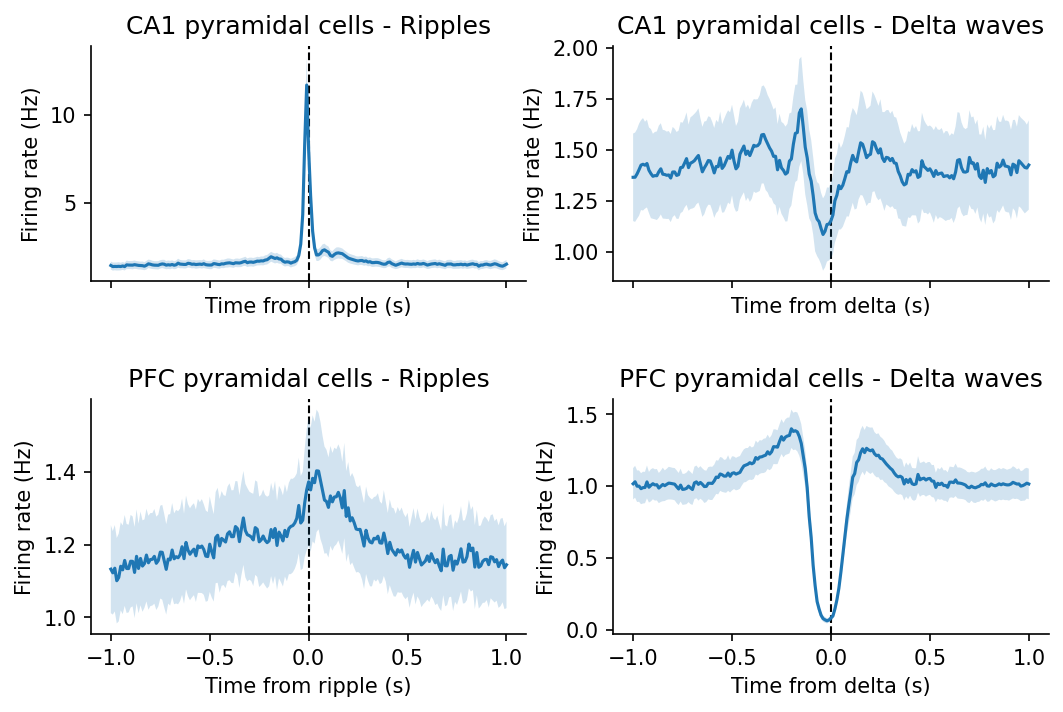

In [4]:
# restrict spike trains to NREM epochs only for state-specific analysis
st_nrem = st[sleep_states["NREMstate"]]

# Compute PETH for all pyramidal cells aligned to ripples
# Returns DataFrame with shape (n_time_bins, n_units)
peth_st_swr = peth(
    st_nrem,
    ripples.data[0, :],
    bin_width=bin_width,
    window=window,
)

# Compute PETH for all pyramidal cells aligned to delta waves
peth_st_delta = peth(
    st_nrem,
    deltas.data[0, :],
    bin_width=bin_width,
    window=window,
)

# Index by brain region for visualization
peth_st_swr_ca1 = peth_st_swr.iloc[:, ca1_idx]
peth_st_swr_pfc = peth_st_swr.iloc[:, pfc_idx]
peth_st_delta_ca1 = peth_st_delta.iloc[:, ca1_idx]
peth_st_delta_pfc = peth_st_delta.iloc[:, pfc_idx]

# Create 2×2 subplot grid: rows=regions (CA1, PFC), columns=event types (ripples, deltas)
fig, axes = plt.subplots(
    2,
    2,
    figsize=npy.plotting.set_size("paper", 1, subplots=(2, 2)),
    sharex=True,  # Share x-axis for easy comparison
    dpi=150,
)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

# Plot PETH results: plot_peth_fast() shows mean ± SEM
npy.plotting.plot_peth_fast(peth_st_swr_ca1, ax=axes[0, 0])
npy.plotting.plot_peth_fast(peth_st_delta_ca1, ax=axes[0, 1])
npy.plotting.plot_peth_fast(peth_st_swr_pfc, ax=axes[1, 0])
npy.plotting.plot_peth_fast(peth_st_delta_pfc, ax=axes[1, 1])

# Add vertical line at event time (t=0) for visual reference
for ax in axes.ravel():
    ax.axvline(0, color="k", ls="--", lw=1, zorder=-10)  # Event marker
    ax.set_ylabel("Firing rate (Hz)")

# Label axes by event type
axes[0, 0].set_xlabel("Time from ripple (s)")
axes[0, 1].set_xlabel("Time from delta (s)")
axes[1, 0].set_xlabel("Time from ripple (s)")
axes[1, 1].set_xlabel("Time from delta (s)")

# Label axes by brain region and event type
axes[0, 0].set_title("CA1 pyramidal cells - Ripples")
axes[0, 1].set_title("CA1 pyramidal cells - Delta waves")
axes[1, 0].set_title("PFC pyramidal cells - Ripples")
axes[1, 1].set_title("PFC pyramidal cells - Delta waves")

## Calculate PETH for Continuous Data

### Analysis Goals
Unlike spike trains (discrete events), continuous signals like LFP directly reflect the voltage dynamics of local neural populations. We compute event-triggered averages of LFP on three channels to visualize how local field potentials modulate around ripples and delta waves.

**Channels analyzed:**
1. **Ripple channel (261)**: CA1 pyramidal layer—site of ripple generation
2. **Sharp wave channel (282)**: CA1 region—source of sharp-wave component
3. **Delta channel (53)**: PFC channel with delta oscillations

**Why NREM sleep?** Both ripples and delta waves occur preferentially during NREM sleep. Restricting analysis to NREM ensures we examine the same behavioral state across both event types, controlling for state-dependent changes in LFP amplitude.

### Method
For each channel, we average the continuous LFP signal across all ripple events (or delta events) and plot mean ± SEM. Sharp voltage deflections at t=0 indicate synchronization of the underlying neural population to the event.

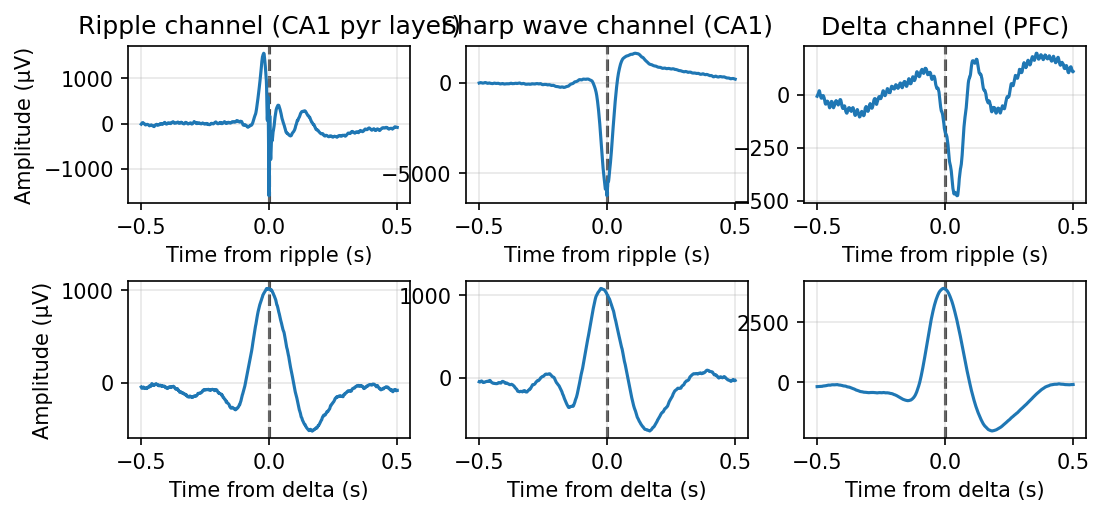

In [5]:
# Restrict LFP analysis to NREM sleep epochs only
# Sleep states have state-dependent effects on spike rates and LFP oscillations
# NREM is standardized across animals, enabling clean signal averaging
lfp_idx = npy.process.in_intervals(ts, sleep_states["NREMstate"].data)

# Create AnalogSignalArray with three channels of interest
# data shape after selection: (3 channels, nTimepoints_in_NREM)
# when we index lfp, we load lfp into memory
lfp_asa = nel.AnalogSignalArray(
    data=lfp[lfp_idx, :][:, [ripple_channel, sharp_wave_channel, delta_channel]].T,
    abscissa_vals=ts[lfp_idx],  # Time vector aligned to selected epochs
)

# Compute event-triggered averages of LFP around ripples
# Window = [-0.5, 0.5] sec provides finer temporal resolution for fast LFP dynamics
# bin_width = 1/1250 sec = 0.8 ms (matched to LFP sampling rate)
peth_lfp_swr = peth(lfp_asa, ripples.data[0, :], bin_width=1 / 1250, window=[-0.5, 0.5])

# Compute event-triggered averages of LFP around delta waves
peth_lfp_delta = peth(
    lfp_asa, deltas.data[0, :], bin_width=1 / 1250, window=[-0.5, 0.5]
)

# Create 2×3 subplot grid: rows=event type (ripples, deltas), columns=channels (ripple, sharp wave, delta)
fig, axes = plt.subplots(
    2, 3, figsize=npy.plotting.set_size("paper", 1, subplots=(2, 3)), dpi=150
)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes = axes.ravel()

# Top row: LFP modulation during ripple events
peth_lfp_swr.iloc[:, 0].plot(ax=axes[0])
peth_lfp_swr.iloc[:, 1].plot(ax=axes[1])
peth_lfp_swr.iloc[:, 2].plot(ax=axes[2])

# Bottom row: LFP modulation during delta wave events
peth_lfp_delta.iloc[:, 0].plot(ax=axes[3])
peth_lfp_delta.iloc[:, 1].plot(ax=axes[4])
peth_lfp_delta.iloc[:, 2].plot(ax=axes[5])

# Label columns by channel (top row titles)
axes[0].set_title("Ripple channel (CA1 pyr layer)")
axes[1].set_title("Sharp wave channel (CA1)")
axes[2].set_title("Delta channel (PFC)")

# Label rows by event type (left column x-labels)
axes[0].set_xlabel("Time from ripple (s)")
axes[1].set_xlabel("Time from ripple (s)")
axes[2].set_xlabel("Time from ripple (s)")

axes[3].set_xlabel("Time from delta (s)")
axes[4].set_xlabel("Time from delta (s)")
axes[5].set_xlabel("Time from delta (s)")

# Label y-axes
axes[0].set_ylabel("Amplitude (μV)")
axes[3].set_ylabel("Amplitude (μV)")

# Add event marker line at t=0 to each plot
for ax_ in axes:
    ax_.axvline(
        0, color="k", ls="--", lw=1.5, alpha=0.7, zorder=-10
    )  # Event onset marker
    ax_.grid(True, alpha=0.3)

## Event-wise PETH Analysis

The `average=True` (default) returns the mean firing rate across all events, which is useful for understanding typical responses. However, sometimes we want to analyze individual events - for example, to:

1. **Identify outlier events** with unusually strong or weak neural responses
2. **Stratify events by response strength** to correlate with behavioral or physiological variables
3. **Examine trial-to-trial variability** in neural dynamics
4. **Sort events** to create raster plots organized by population response

The `average=False` parameter returns event-wise data as a 3D matrix with shape `(n_time_bins, n_signals, n_events)`, preserving information about each individual event.

Event-wise PETH matrix shape: (201, 75, 3848)
  - Time bins: 201
  - CA1 units: 75
  - Ripple events: 3848

Verify: Averaging across events recovers the original PETH:
  Mean absolute difference: 1.90e-16 Hz


Text(0, 0.5, 'Time from SWR (s)')

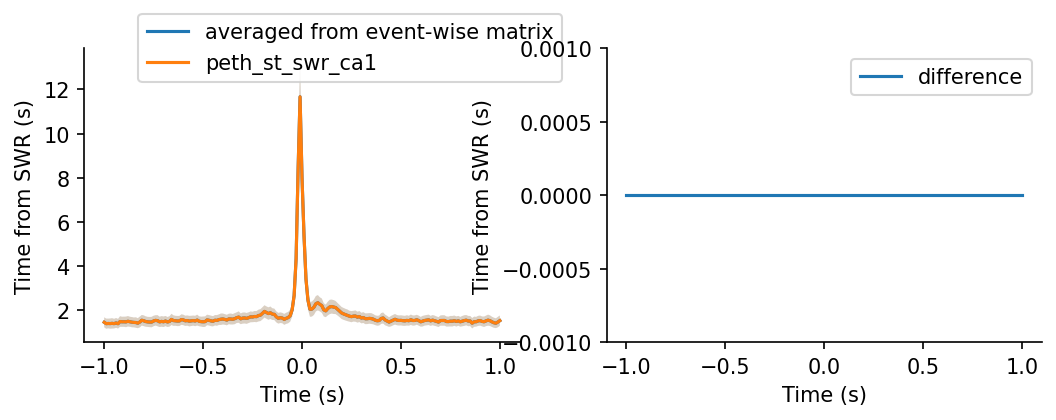

In [6]:
# Get event-wise PETH matrix for CA1 units during ripples
# Returns (n_time_bins, n_units, n_events) instead of averaged DataFrame
peth_matrix_ca1, time_bins = peth(
    st_nrem.iloc[:, ca1_idx],
    ripples.data[0, :],
    bin_width=bin_width,
    window=window,
    average=False,  # Returns individual event responses
)

print(f"Event-wise PETH matrix shape: {peth_matrix_ca1.shape}")
print(f"  - Time bins: {peth_matrix_ca1.shape[0]}")
print(f"  - CA1 units: {peth_matrix_ca1.shape[1]}")
print(f"  - Ripple events: {peth_matrix_ca1.shape[2]}")
print(f"\nVerify: Averaging across events recovers the original PETH:")
manual_avg = np.nanmean(peth_matrix_ca1, axis=2)
print(
    f"  Mean absolute difference: {np.abs(manual_avg - peth_st_swr_ca1.values).mean():.2e} Hz"
)

fig, ax = plt.subplots(
    1, 2, figsize=npy.plotting.set_size("paper", 1, subplots=(1, 2)), dpi=150
)

npy.plotting.plot_peth_fast(
    manual_avg, ts=time_bins, ax=ax[0], label="averaged from event-wise matrix"
)
npy.plotting.plot_peth_fast(peth_st_swr_ca1, ax=ax[0], label="peth_st_swr_ca1")

npy.plotting.plot_peth_fast(
    manual_avg - peth_st_swr_ca1.values, ts=time_bins, ax=ax[1], label="difference"
)
ax[1].set_ylim(-0.001, 0.001)

ax[0].legend(loc="center left", bbox_to_anchor=(0.1, 1))
ax[1].legend()

ax[0].set_ylabel("rate (Hz)")
ax[1].set_ylabel("difference")

ax[0].set_ylabel("Time from SWR (s)")
ax[1].set_ylabel("Time from SWR (s)")


### Example: Stratifying Events by Population Response

With event-wise data, we can quantify the population response strength for each ripple event and stratify them. This allows us to ask: **Do "strong" ripple events (with high CA1 firing) differ from "weak" ones?**

We'll:
1. Compute total population firing rate for each ripple
2. Split ripples into strong/weak groups
3. Visualize how PFC neurons respond differently to strong vs. weak CA1 ripple events

Strong ripples (top 25%): 977 events
Weak ripples (bottom 25%): 965 events
CA1 response - Strong: 2.4 Hz·s
CA1 response - Weak: 1.2 Hz·s

Insight: PFC neurons show 1.31x higher firing during strong CA1 ripples compared to weak ones.


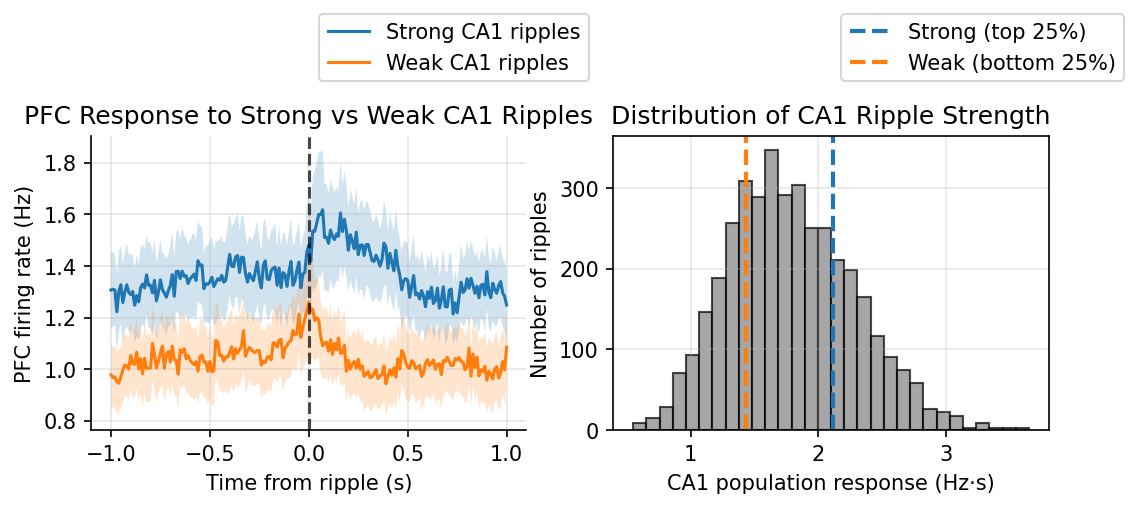

In [7]:
# Calculate population response strength for each ripple event
# Sum firing rate across all CA1 units and time bins within window
ca1_response_per_event = peth_matrix_ca1.mean(
    axis=(0, 1)
)  # Sum over time bins and units

# Stratify ripples: top 25% strongest vs bottom 25% weakest CA1 responses
strong_threshold = np.percentile(ca1_response_per_event, 75)
weak_threshold = np.percentile(ca1_response_per_event, 25)

strong_events = ca1_response_per_event >= strong_threshold
weak_events = ca1_response_per_event <= weak_threshold

print(f"Strong ripples (top 25%): {strong_events.sum()} events")
print(f"Weak ripples (bottom 25%): {weak_events.sum()} events")
print(f"CA1 response - Strong: {ca1_response_per_event[strong_events].mean():.1f} Hz·s")
print(f"CA1 response - Weak: {ca1_response_per_event[weak_events].mean():.1f} Hz·s")


# Now get PFC response for the same ripple events
peth_matrix_pfc, _ = peth(
    st_nrem.iloc[:, pfc_idx],
    ripples.data[0, :],
    bin_width=bin_width,
    window=window,
    average=False,
)

# Average PFC responses separately for strong vs weak CA1 ripple events
pfc_response_strong = np.nanmean(peth_matrix_pfc[:, :, strong_events], axis=2)
pfc_response_weak = np.nanmean(peth_matrix_pfc[:, :, weak_events], axis=2)

print(
    f"\nInsight: PFC neurons show {pfc_response_strong.mean()/pfc_response_weak.mean():.2f}x higher firing "
    f"during strong CA1 ripples compared to weak ones."
)
# Plot comparison
fig, axes = plt.subplots(
    1, 2, figsize=npy.plotting.set_size("paper", 1, subplots=(1, 2)), dpi=150
)

# Average across PFC units for visualization
npy.plotting.plot_peth_fast(
    pfc_response_strong,
    ts=time_bins,
    ax=axes[0],
    label="Strong CA1 ripples",
)

npy.plotting.plot_peth_fast(
    pfc_response_weak,
    ts=time_bins,
    ax=axes[0],
    label="Weak CA1 ripples",
)

axes[0].axvline(0, color="k", ls="--", lw=1.5, alpha=0.7)
axes[0].set_xlabel("Time from ripple (s)")
axes[0].set_ylabel("PFC firing rate (Hz)")
axes[0].set_title("PFC Response to Strong vs Weak CA1 Ripples")
axes[0].legend(loc="center left", bbox_to_anchor=(0.5, 1.3))
axes[0].grid(True, alpha=0.3)

# Show distribution of CA1 response strength
axes[1].hist(
    ca1_response_per_event, bins=30, alpha=0.7, color="gray", edgecolor="black"
)
axes[1].axvline(strong_threshold, color="C0", ls="--", lw=2, label=f"Strong (top 25%)")
axes[1].axvline(weak_threshold, color="C1", ls="--", lw=2, label=f"Weak (bottom 25%)")
axes[1].set_xlabel("CA1 population response (Hz·s)")
axes[1].set_ylabel("Number of ripples")
axes[1].set_title("Distribution of CA1 Ripple Strength")
axes[1].legend(loc="center left", bbox_to_anchor=(0.5, 1.3))
axes[1].grid(True, alpha=0.3)


plt.show()


### Example: Sorting Events by Response Latency

Another powerful use of event-wise data is to sort events by neural response timing. This reveals temporal structure in event sequences - for example, whether some ripples elicit faster PFC responses than others.

PFC response latency range: [-1.000, 1.000] seconds
Mean latency: -0.145 s, Median: -0.180 s

The sorted heatmap reveals temporal structure: PFC responses range from -1 s to 1 s after ripple onset.


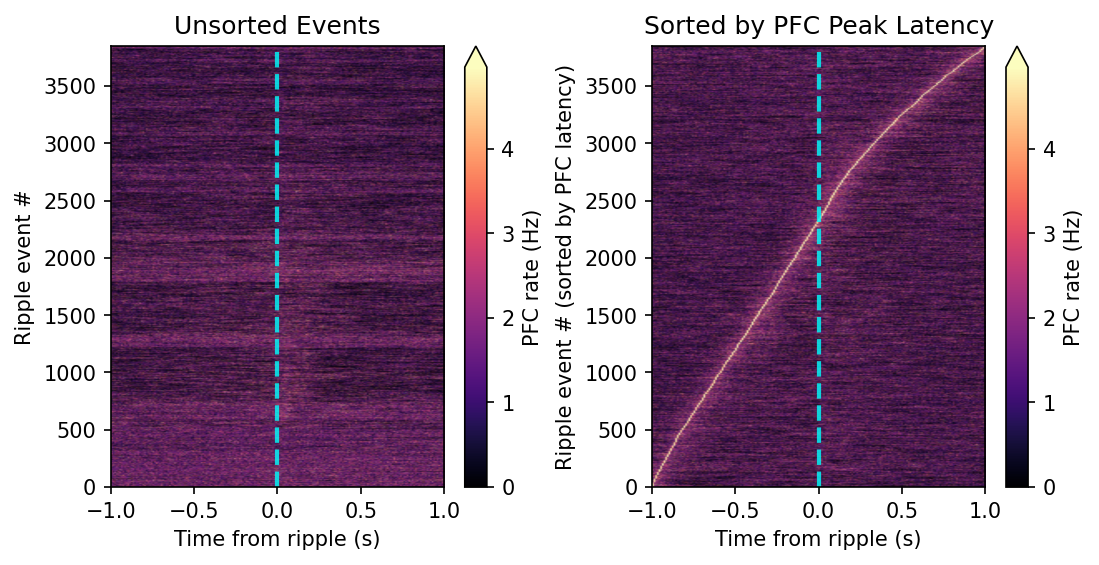

In [13]:
# For each ripple event, find the time of peak PFC population response
# Average across all PFC units to get population response per event
pfc_population_response = peth_matrix_pfc.mean(axis=1)  # Shape: (n_time_bins, n_events)

# Find time bin of peak response for each event
peak_time_idx = np.argmax(pfc_population_response, axis=0)
peak_times = time_bins[peak_time_idx]

# Sort events by peak response time
sort_order = np.argsort(peak_times)

print(
    f"PFC response latency range: [{peak_times.min():.3f}, {peak_times.max():.3f}] seconds"
)
print(f"Mean latency: {peak_times.mean():.3f} s, Median: {np.median(peak_times):.3f} s")

print(
    f"\nThe sorted heatmap reveals temporal structure: PFC responses range from "
    f"{peak_times.min():.0f} s to {peak_times.max():.0f} s after ripple onset."
)

# Create heatmap of PFC population response, sorted by latency
fig, axes = plt.subplots(
    1, 2, figsize=npy.plotting.set_size("paper", 1, subplots=(1.5, 2)), dpi=150
)
plt.subplots_adjust(wspace=0.3)
# Left: Unsorted events
im1 = axes[0].imshow(
    pfc_population_response.T,  # Events as rows
    aspect="auto",
    extent=[time_bins[0], time_bins[-1], 0, ripples.n_events[0]],
    cmap="magma",
    interpolation="gaussian",
    origin="lower",
    vmin=0,
    vmax=np.percentile(pfc_population_response, 99),
)
axes[0].axvline(0, color="cyan", ls="--", lw=2, alpha=0.8)
axes[0].set_xlabel("Time from ripple (s)")
axes[0].set_ylabel("Ripple event #")
axes[0].set_title("Unsorted Events")
plt.colorbar(im1, ax=axes[0], label="PFC rate (Hz)", extend="max")

# Right: Sorted by peak response time
im2 = axes[1].imshow(
    pfc_population_response[:, sort_order].T,  # Sorted events
    aspect="auto",
    extent=[time_bins[0], time_bins[-1], 0, ripples.n_events[0]],
    cmap="magma",
    interpolation="gaussian",
    origin="lower",
    vmin=0,
    vmax=np.percentile(pfc_population_response, 99),
)
axes[1].axvline(0, color="cyan", ls="--", lw=2, alpha=0.8)

axes[1].set_xlabel("Time from ripple (s)")
axes[1].set_ylabel("Ripple event # (sorted by PFC latency)")
axes[1].set_title("Sorted by PFC Peak Latency")
plt.colorbar(im2, ax=axes[1], label="PFC rate (Hz)", extend="max")
axes[0].grid(False)
axes[1].grid(False)
plt.show()



### Example: Joint Peri-Event Time Histograms (JPST) - Controlling for Confounds



**Question**: Does PFC respond specifically to ripples, or is the response just due to coinciding delta waves?

Since ripples and delta waves are temporally coupled during NREM sleep, we need to **dissociate their effects**. 
Joint peri-event time histograms (JPST) solve this by showing:
1. **PFC response to ripples** (observed effect)
2. **Delta wave occurrence aligned to ripples** (confound structure)

By visualizing both together, we can see if PFC responses are ripple-specific or merely reflect 
the timing of delta waves.


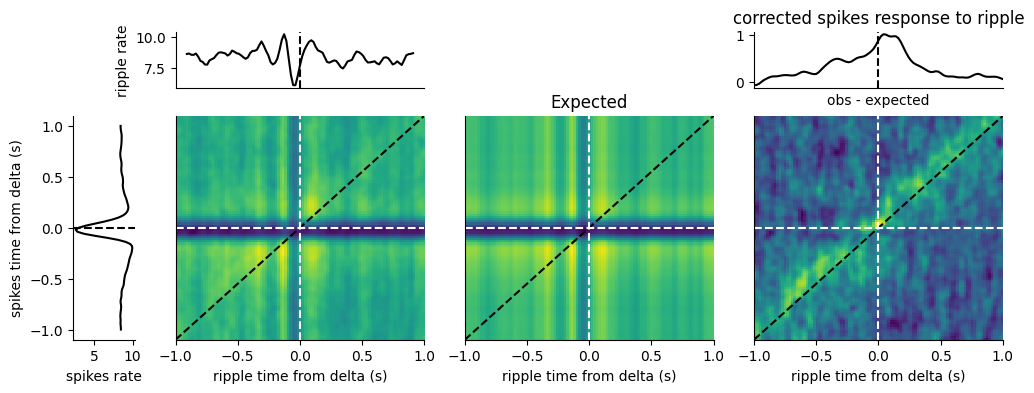

In [ ]:
window = [-1, 1]
labels = ["spikes", "ripple", "delta"]

# get event-wise PETH matrix for PFC units during delta waves
peth_1, ts = peth(
    st_nrem.iloc[:, pfc_idx].flatten(),
    deltas.data[0, :],
    bin_width=0.02,
    window=[-1, 1],
    average=False,
)
# get event-wise PETH matrix for ripples during delta waves
peth_2, ts = peth(
    ripples.data[0, :], deltas.data[0, :], bin_width=0.02, window=[-1, 1], average=False
)

npy.plotting.figure_helpers.plot_joint_peth(
    peth_1[:, 0, :].T, peth_2[:, 0, :].T, ts, labels=labels, smooth_std=1
)

plt.show()

### Takeaways: Event-wise PETH Analysis

The `average=False` parameter unlocks powerful analyses beyond simple averaging:

✅ **Event stratification**: Identify subpopulations of events with distinct neural correlates  
✅ **Correlation analysis**: Relate event-by-event neural responses to behavioral or physiological variables  
✅ **Temporal sorting**: Reveal latency structure in event sequences  
✅ **Outlier detection**: Find unusual events for closer examination  
✅ **Variability quantification**: Measure trial-to-trial consistency of neural responses

**When to use:**
- `average=True` (default): Standard PETH plots showing typical response
- `average=False`: When you need event-level granularity for stratification, sorting, or correlation analyses

The event-wise matrix preserves all information, allowing flexible post-hoc analyses without recomputing PETHs.